## Shallow water equations prediction error analysis

In [1]:
import sys
print("Python version: {}".format(sys.version))

Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import scipy.stats as st
import matplotlib.pyplot as plt
#import datetime
import matplotlib.dates as mdates

path = "../data/"
prepared_path = path+"prepared/"

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100 #

#### Utils
Function determining categorical wind direction based on the direction given in degrees

In [3]:
def wind_direction(AL1_value):
    AL_bins = np.linspace(0,  360, 17, endpoint=True) - 22.5/2
    directions = ["N","NNE","NE","ENE","E","ESE","SE","SSE","S","SSW","SW","WSW","W","WNW","NW","NNW"]
    for i in range(1,len(AL_bins)):
        if AL1_value <= AL_bins[i]:
            return(directions[i-1])
    return np.nan

### Data import

In [4]:
df_error = pd.read_pickle(prepared_path+"df_error.pkl")
df_error["error"] = df_error["observations"] - df_error["predictions"]
df_error.head(3)

,date,observations,predictions,error
0,2008-01-01,0.246,0.25,-0.004
1,2008-01-02,0.223,0.18,0.043
2,2008-01-03,0.056,0.00,0.056


In [5]:
df_wind = pd.read_pickle(prepared_path+"df_wind.pkl")
#df_wind["date"] = list(map(lambda r:r.date(),df_wind["date_time"]))
df_wind["AL1"] = np.array(list(map(wind_direction,df_wind["AL [st]"]))) # adding a categorical wind direction
df_wind.head(3)

,date_time,AL [st],W [m/s],AL1
0,2008-01-01 00:00:00,151.83,2.50,SSE
1,2008-01-01 01:00:00,151.83,2.50,SSE
2,2008-01-01 02:00:00,155.17,2.78,SSE


In [6]:
df_water_stage = pd.read_pickle(prepared_path+"df_water_stage.pkl")
df_water_stage.head(3)

,data,Hel (A),Tolkmicko (C),A [m npm],C [m npm],A-num,C-num
0,2008-01-01,524.8,532.6,0.248,0.246,0.25,0.25
1,2008-01-02,515.8,530.3,0.158,0.223,0.16,0.18
2,2008-01-03,495.1,513.6,-0.049,0.056,-0.05,0.00


In [7]:
df_wind_mean = df_wind[["AL [st]","W [m/s]","date_time"]].groupby(list(map(lambda r:r.date(),df_wind["date_time"]))).mean()
df_wind_mean["AL1"] = np.array(list(map(wind_direction,df_wind_mean["AL [st]"])))
del df_wind_mean["date_time"]
df_wind_mean.columns = ["ALmean", "Wmean", "ALmean_dir"]
df_wind_mean.head(3)

,ALmean,Wmean,ALmean_dir
2008-01-01,125.145833,2.987083,SE
2008-01-02,96.076250,3.918333,E
2008-01-03,115.194583,5.970000,ESE


#### Finding the maximum wind velocity and the most frequent wind direction

In [8]:
df_wind_max = df_wind.groupby(list(map(lambda r:r.date(),df_wind["date_time"]))).agg({"W [m/s]":max, 
                                                                                       # get 3 most frequent wind directions
                                                                                      "AL1": lambda x: tuple(map(lambda tp: tp[0],Counter(x).most_common(3)))}) 
df_wind_max.columns = ["Wmax", "ALfreq"]
df_wind_max.head(3)

,Wmax,ALfreq
2008-01-01,4.20,"(ESE, SSE, SE)"
2008-01-02,5.67,"(ESE, ENE, E)"
2008-01-03,9.28,"(ESE, SE)"


#### Highest wind velocity daily maxima and most frequent winds

In [9]:
df_wind_max.sort_values("Wmax",ascending=False).head(10)

,Wmax,ALfreq
2017-12-31,35.27,"(SSE, W, SE)"
2017-12-30,31.15,"(SSE, SSW, S)"
2017-12-29,24.32,"(WSW, SW, SSW)"
2017-12-26,21.35,"(SSW, SW, S)"
2015-12-07,21.23,"(W, WSW, SW)"
2011-11-28,21.00,"(W, WNW, NW)"
2017-12-28,20.42,"(SSE, SE, S)"
2011-02-08,20.13,"(W, SW, WSW)"
2017-12-24,19.87,"(WSW, W, WNW)"
2008-01-26,19.73,"(W, WSW, NW)"


#### Join (by date) modelling error and aggregated wind dataframes

In [10]:
df_error_wind = df_error.set_index("date").join(df_wind_mean)
df_error_wind = df_error_wind.join(df_wind_max[["ALfreq","Wmax"]])
df_error_wind.head(3)

,observations,predictions,error,ALmean,Wmean,ALmean_dir,ALfreq,Wmax
date,,,,,,,,
2008-01-01,0.246,0.25,-0.004,125.145833,2.987083,SE,"(ESE, SSE, SE)",4.20
2008-01-02,0.223,0.18,0.043,96.076250,3.918333,E,"(ESE, ENE, E)",5.67
2008-01-03,0.056,0.00,0.056,115.194583,5.970000,ESE,"(ESE, SE)",9.28


### Shallow water equations model outcomes analysis

#### Regression of predictions vs. observations

In [11]:
x = df_error["observations"].to_numpy()
y = df_error["predictions"].to_numpy()

a, b, r_value, p_value, std_err = st.linregress(x,y)
print("y={:.3}*x".format(a)+str("+" if b>0 else "")+"{:.3}".format(b))

y=0.916*x-0.0443


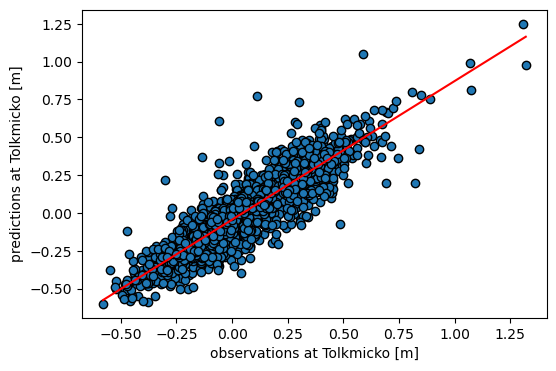

In [12]:
plt.scatter(df_error["observations"],df_error["predictions"],edgecolor = "black")
plt.plot([min(x),max(x)],[a*min(x)+b,a*max(x)+b],color="red")
plt.xlabel("observations at Tolkmicko [m]")
plt.ylabel("predictions at Tolkmicko [m]")
pass

#### Displaying only points with high errors and assigning dates to the points

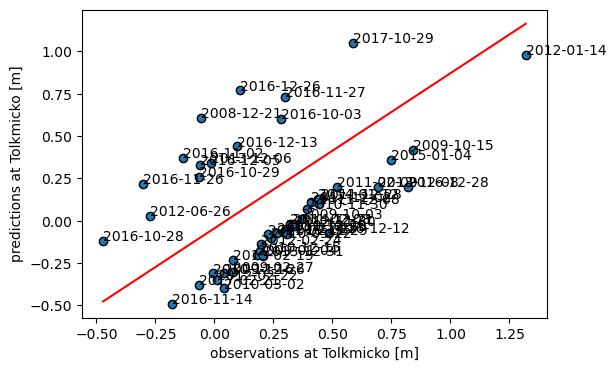

In [13]:
cond = np.abs(df_error["error"])>0.3
x = df_error.loc[cond,"observations"]
y = df_error.loc[cond,"predictions"]

plt.scatter(x,y,edgecolor = "black")
plt.plot([min(x),max(x)],[a*min(x)+b,a*max(x)+b],color="red")
plt.xlabel("observations at Tolkmicko [m]")
plt.ylabel("predictions at Tolkmicko [m]")

for i,(x,y,t) in enumerate(zip(x,y,df_error.loc[cond,"date"].dt.date)):
    plt.text(x,y,t)
    
pass

#### Displaying water stage predictions vs. observations with maximum wind velocity as colour

Text(0, 0.5, 'max W [m/s]')

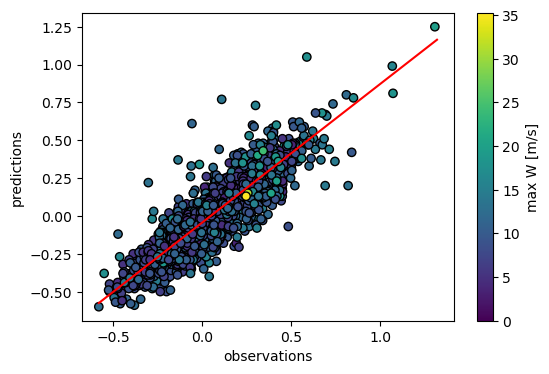

In [14]:
x = df_error["observations"]
y = df_error["predictions"]
plt.scatter(df_error_wind["observations"],df_error_wind["predictions"],edgecolor = "black", c = df_error_wind["Wmax"])
plt.plot([min(x),max(x)],[a*min(x)+b,a*max(x)+b],color="red")
plt.xlabel("observations")
plt.ylabel("predictions")
cbar = plt.colorbar()
cbar.ax.set_ylabel('max W [m/s]') 

#### Predictions error histogram

Text(0, 0.5, 'density')

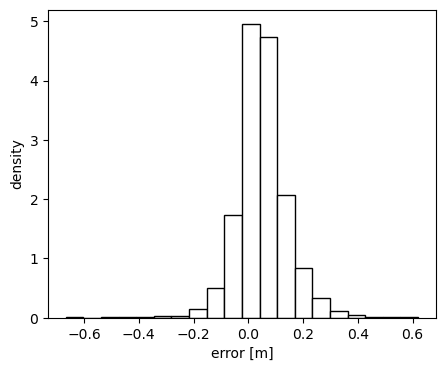

In [15]:
plt.rcParams['figure.figsize'] = [5, 4]
plt.rcParams['figure.dpi'] = 100 #

x = df_error["observations"]
y = df_error["predictions"]
err = x-y
plt.hist(err,bins=20,color="white",edgecolor="black",density=True)
plt.xlabel("error [m]")
plt.ylabel("density")

In [16]:
np.mean(err)

0.04927060273972602

what happened in 2009 and 2017?

In [17]:
np.quantile(err,[0.25,0.5,0.75])

array([0.    , 0.0455, 0.096 ])

In [18]:
[np.min(err),np.max(err)]

[-0.6669999999999998, 0.6199999999999999]

#### Checking the period with no wind information (Jan 2012)

In [19]:
# importing the wind
df_wind = pd.read_pickle(prepared_path+"df_wind.pkl")
df_wind.head()

,date_time,AL [st],W [m/s]
0,2008-01-01 00:00:00,151.83,2.50
1,2008-01-01 01:00:00,151.83,2.50
2,2008-01-01 02:00:00,155.17,2.78
3,2008-01-01 03:00:00,161.50,2.45
4,2008-01-01 04:00:00,142.00,2.75


In [20]:
df_wind.isna().sum()

date_time      0
AL [st]      744
W [m/s]      744
dtype: int64

In [21]:
df_no_wind = df_wind.loc[df_wind["W [m/s]"].isna()==True]
df_no_wind.head()

,date_time,AL [st],W [m/s]
1,2012-01-01 01:00:00,NaN,NaN
2,2012-01-01 02:00:00,NaN,NaN
3,2012-01-01 03:00:00,NaN,NaN
4,2012-01-01 04:00:00,NaN,NaN
5,2012-01-01 05:00:00,NaN,NaN


In [22]:
min_date = df_no_wind["date_time"].min()
max_date = df_no_wind["date_time"].max()
[min_date, max_date]

[Timestamp('2012-01-01 01:00:00'), Timestamp('2012-02-01 00:00:00')]

In [23]:
df_error.head()

,date,observations,predictions,error
0,2008-01-01,0.246,0.25,-0.004
1,2008-01-02,0.223,0.18,0.043
2,2008-01-03,0.056,0.00,0.056
3,2008-01-04,-0.160,-0.16,0.000
4,2008-01-05,-0.227,-0.33,0.103


In [24]:
df_error["date"]

0      2008-01-01
1      2008-01-02
2      2008-01-03
3      2008-01-04
4      2008-01-05
          ...    
3645   2017-12-27
3646   2017-12-28
3647   2017-12-29
3648   2017-12-30
3649   2017-12-31
Name: date, Length: 3650, dtype: datetime64[ns]

In [25]:
cond = (df_error["date"]  >min_date) & (df_error["date"]<max_date)
x = df_error.loc[cond,"observations"].to_numpy()
y = df_error.loc[cond,"predictions"].to_numpy()

a, b, r_value, p_value, std_err = st.linregress(x,y)
print("y={:.3}*x".format(a)+str("+" if b>0 else "")+"{:.3}".format(b))

y=0.736*x+0.103


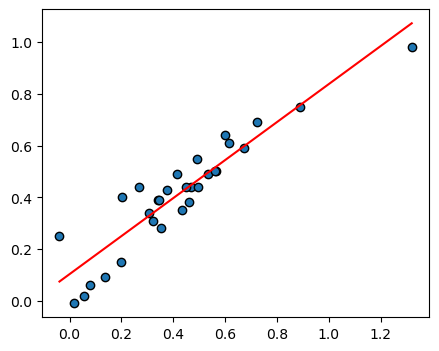

In [26]:
plt.scatter(x,y,edgecolor = "black")
plt.plot([min(x),max(x)],[a*min(x)+b,a*max(x)+b],color="red")

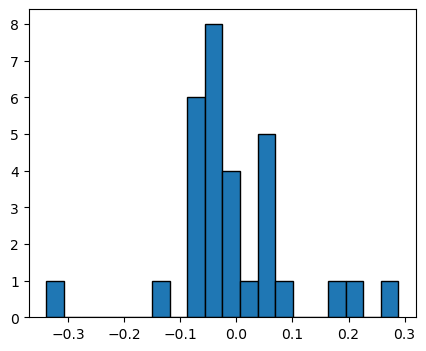

In [27]:
err = y-x
plt.hist(err,bins=20,edgecolor="black")
pass

### Error vs. time
Plot displays error, water stage at Hel and Tolkmicko, wind direction and wind velocity

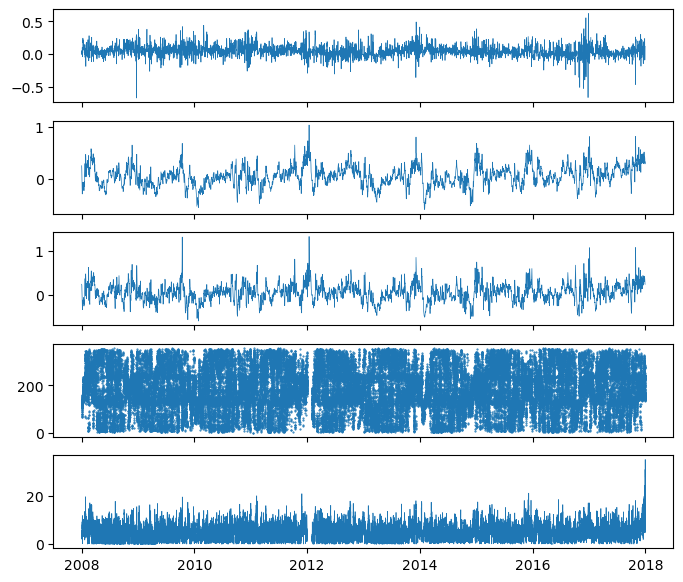

In [28]:
fig,ax = plt.subplots(5,1,figsize=(8, 7),sharex=True)

ax[0].plot(df_error["date"],df_error["error"],linewidth=0.5)
ax[1].plot(df_water_stage["data"],df_water_stage[" A [m npm]"],linewidth=0.5)
ax[2].plot(df_water_stage["data"],df_water_stage[" C [m npm]"],linewidth=0.5)
ax[3].scatter(df_wind["date_time"],df_wind["AL [st]"],s=0.25)
ax[4].plot(df_wind["date_time"],df_wind["W [m/s]"],linewidth=0.5)
pass

#### Density plot of wind speed and error

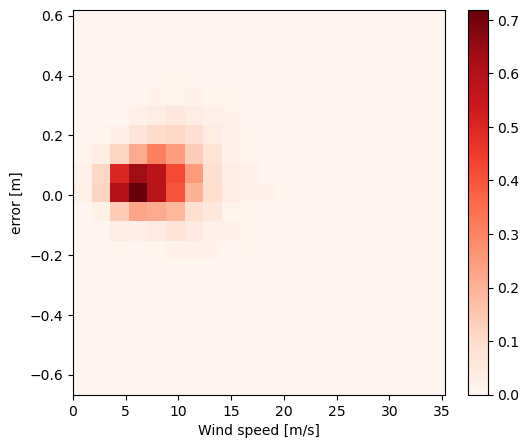

In [29]:
plt.rcParams['figure.figsize'] = [6, 5]
plt.rcParams['figure.dpi'] = 100 #

df_error_wind_tmp = df_error_wind.dropna()

plt.hist2d(df_error_wind_tmp["Wmax"],df_error_wind_tmp["error"],bins=20,density=True,cmap=plt.cm.Reds)
plt.colorbar()
plt.xlabel("Wind speed [m/s]")
plt.ylabel("error [m]")
pass

#### Density plot of wind direction and error

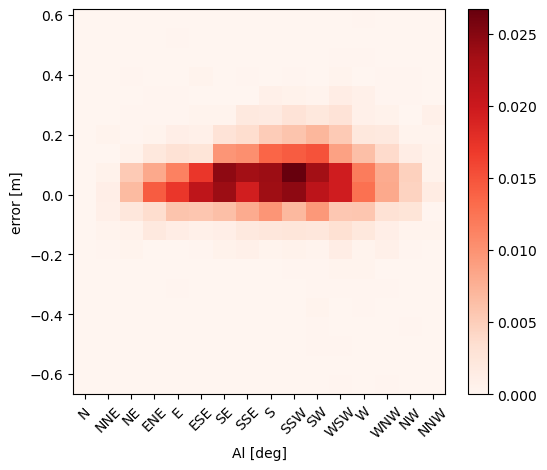

In [30]:
directions = ["N","NNE","NE","ENE","E","ESE","SE","SSE","S","SSW","SW","WSW","W","WNW","NW","NNW"]

AL_bins = np.linspace(0,  360, 17, endpoint=True) - 22.5/2
ax = plt.axes()
plt.hist2d(df_error_wind["ALmean"].to_numpy(),df_error_wind["error"].to_numpy(),bins=[AL_bins,20],density=True,cmap=plt.cm.Reds)
plt.colorbar()
plt.xlabel("Al [deg]")
plt.ylabel("error [m]")

xt = np.linspace(0,  360, 16, endpoint=False)
ax.set_xticks(xt)
ax.set_xticklabels(directions)
plt.xticks(rotation=45)

pass

#### Plot of mean wind speed and error with maximum daily wind speed as colour

Text(0, 0.5, 'max W [m/s]')

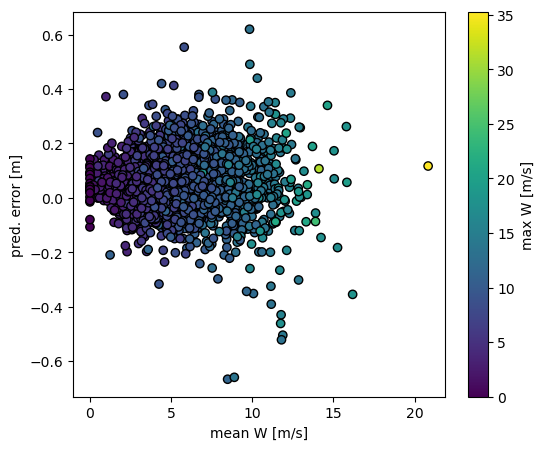

In [31]:
plt.scatter(df_error_wind["Wmean"],df_error_wind["error"],edgecolor = "black",c=df_error_wind["Wmax"])
plt.xlabel("mean W [m/s]")
plt.ylabel("pred. error [m]")
cbar = plt.colorbar()
cbar.ax.set_ylabel('max W [m/s]')